In [1]:
import os
import random

import numpy as np
import wfdb
import pandas as pd
from sklearn.model_selection import train_test_split
from deep_translator import GoogleTranslator

In [2]:
os.chdir('..')

In [3]:
data = pd.read_csv('data_ptb-xl/ptbxl_database.csv')
data = data.loc[data['report'] != ' '] # remove 2 rows without a report
data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


## Train - Val - Test Split

In [6]:
# Split the data based on the patient IDs
train = data[~data['strat_fold'].isin([9, 10])].copy()
val = data[data['strat_fold'] == 9].copy()
test = data[data['strat_fold'] == 10].copy()

print(f"train: {round(len(train) / len(data) * 100, 2)} %")
print(f"val:   {round(len(val) / len(data) * 100, 2)} %")
print(f"test:  {round(len(test) / len(data) * 100, 2)} %")

train: 79.91 %
val:   10.02 %
test:  10.08 %


# Translate into English
[paper](https://arxiv.org/pdf/2103.11011.pdf)
[github](https://github.com/danikiyasseh/RTLP/blob/main/translate_ptbxl_text.py)

In [5]:
translator = GoogleTranslator(source='auto', target='en')

def translate_to_english(text):
    try:
        translated = translator.translate(text)
        return translated
    except Exception as e:
        print(f"Error translating text: {e}")
        return text

translate_to_english("Das ist ein test Text!")

'This is a test text!'

# Preprocessing Text

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer


# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [15]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

pattern = re.compile(r'\W')


def preprocess_text(text):
    try:
        text = translate_to_english(text)
        
        # Lowercasing
        text = text.lower()
        
        # Removing punctuation
        text = pattern.sub(' ', text)
        
        # Tokenization
        tokens = word_tokenize(text)
        
        # Removing stop words and lemmatization
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        tokens = ['ecg' if word == 'ekg' else word for word in tokens]
        
        return ' '.join(tokens)
    except Exception as e:
        print(e)
        print(text)
        return None

preprocess_text("Das ist ein test Text! ekg")

'test text ecg'

In [44]:
train['preprocessed_report'] = train['report'].apply(preprocess_text)
train.to_csv('data_ptb-xl/train.csv', index=False)

In [20]:
val['preprocessed_report'] = val['report'].apply(preprocess_text)
val.to_csv('data_ptb-xl/val.csv', index=False)

In [21]:
test['preprocessed_report'] = test['report'].apply(preprocess_text)
test.to_csv('data_ptb-xl/test.csv', index=False)

In [6]:
all_words = train['report'].str.split().explode()
unique_words = set(all_words)
print(f"Number of unique words in report: {len(unique_words)}")

Number of unique words in report: 3549


In [7]:
all_words = train['preprocessed_report'].str.split().explode()
unique_words = set(all_words)
print(f"Number of unique words in preprocessed report: {len(unique_words)}")

Number of unique words in preprocessed report: 1657


# Bag of Words

In [15]:
n_words = 50

In [16]:
train = pd.read_csv('data_ptb-xl/train.csv')

vectorizer = CountVectorizer(max_features=n_words, binary=True)
train_BoW = vectorizer.fit_transform(train['preprocessed_report'])

train_BoW = pd.DataFrame(train_BoW.toarray(), columns=vectorizer.get_feature_names_out())
train_BoW = pd.concat([train['ecg_id'].reset_index(drop=True), train_BoW], axis=1)
train_BoW['ecg_id'] = train_BoW['ecg_id'].astype(int)

train_BoW.to_csv(f'data_ptb-xl/bag_of_words/train_{n_words}_BoW.csv', index=False)

In [17]:
val = pd.read_csv('data_ptb-xl/val.csv')

val_BoW = vectorizer.transform(val['preprocessed_report'])

val_BoW = pd.DataFrame(val_BoW.toarray(), columns=vectorizer.get_feature_names_out())
val_BoW = pd.concat([val['ecg_id'].reset_index(drop=True), val_BoW], axis=1)
val_BoW['ecg_id'] = val_BoW['ecg_id'].astype(int)

val_BoW.to_csv(f'data_ptb-xl/bag_of_words/val_{n_words}_BoW.csv', index=False)

In [18]:
test = pd.read_csv('data_ptb-xl/test.csv')

test_BoW = vectorizer.transform(test['preprocessed_report'])

test_BoW = pd.DataFrame(test_BoW.toarray(), columns=vectorizer.get_feature_names_out())
test_BoW = pd.concat([test['ecg_id'].reset_index(drop=True), test_BoW], axis=1)
test_BoW['ecg_id'] = test_BoW['ecg_id'].astype(int)

test_BoW.to_csv(f'data_ptb-xl/bag_of_words/test_{n_words}_BoW.csv', index=False)

In [9]:
for word in train_BoW.columns:
    print(word, end=', ')

030315, 04, 05, 10, 100, 101, 102, 11, 110, 111, 112, 12, 125, 128, 13, 14, 140, 15, 150, 16, 166, 17, 170, 18, 180, 19, 190, 195, 1avb, 1mg, 1st, 1sves, 1v1, 1v2, 1x0, 1x1, 1x2, 20, 200, 205, 21, 22, 225, 23, 24, 25, 26, 265, 27, 28, 280, 29, 2amp, 2nd, 2v2, 2x, 2x1, 30, 31, 32, 34, 35, 35mm, 37, 38, 39, 3and, 3mv, 3x1, 3x2, 40, 41, 42, 44, 46, 47, 48, 50, 51, 52, 55, 60, 62, 63, 68, 70, 72, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 87, 8m, 8v, 90, 91, 910218, 910220, 910305, 910307, 910308, 92, 93, 98, 99, ab, aber, aberrant, abg, abgänge, abitus, abl, able, abn, abnormal, abnormality, abnormally, absence, absent, accelerated, accord, according, activation, activity, actual, actually, acute, adalat, added, additional, additionally, adequate, adequately, advised, affection, afl, afterload, age, aggravated, ago, ahf, akinesia, allgemein, almi, almost, also, alter, alternately, alternating, amax, amended, ami, amp, amplitude, amplituden, anamnesis, anamnestic, aneur, aneurysm, anged, ange

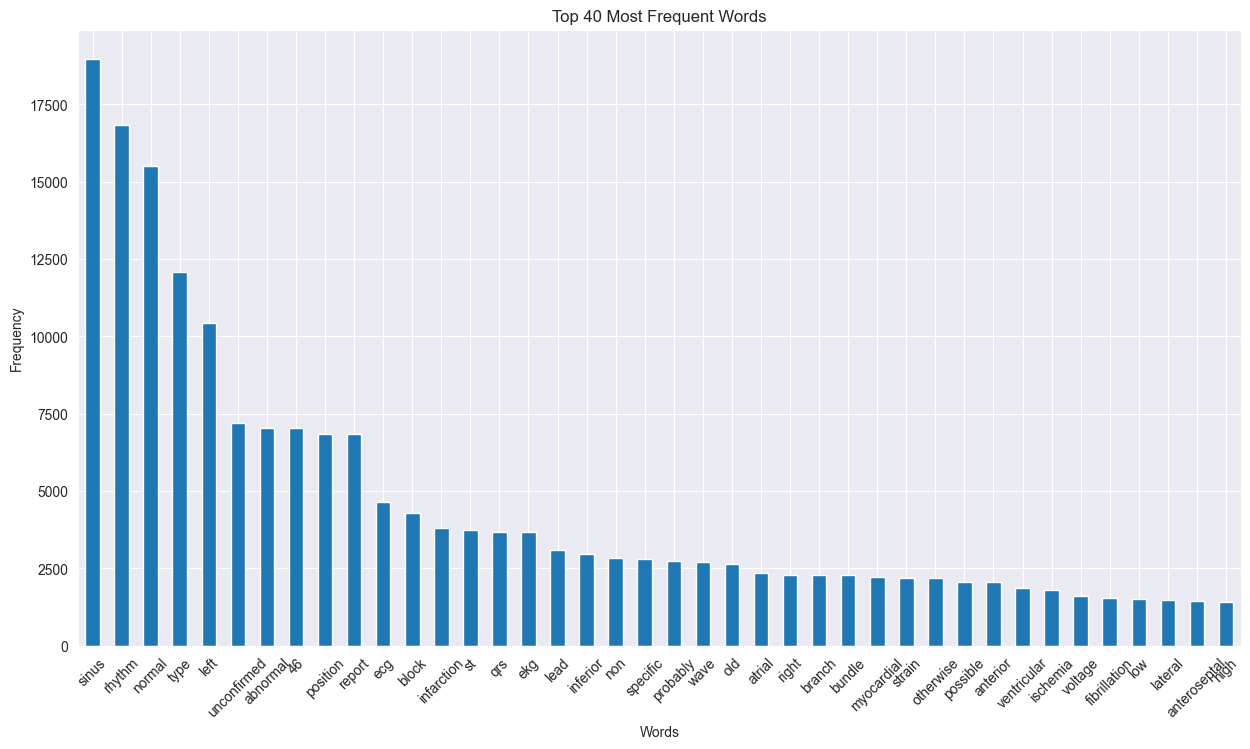

In [13]:
import matplotlib.pyplot as plt


word_counts = train_BoW.sum(axis=0).sort_values(ascending=False)
top_20_words = word_counts.head(40)

plt.figure(figsize=(15, 8))
top_20_words.plot(kind='bar')
plt.title('Top 40 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [30]:
data.loc[data['report'].str.contains('46')]

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
3054,3069,10781.0,55.0,0,NaN,NaN,1.0,2.0,AT-60 3,1989-07-09 15:01:09,...,True,NaN,NaN,NaN,NaN,NaN,NaN,1,records100/03000/03069_lr,records500/03000/03069_hr
3194,3209,9254.0,73.0,1,NaN,NaN,1.0,2.0,AT-60 3,1989-07-27 16:43:23,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/03000/03209_lr,records500/03000/03209_hr
3215,3230,18090.0,300.0,1,NaN,NaN,1.0,2.0,AT-60 3,1989-07-29 17:13:38,...,True,NaN,", alles,",NaN,NaN,NaN,NaN,7,records100/03000/03230_lr,records500/03000/03230_hr
4303,4323,18026.0,60.0,1,NaN,NaN,0.0,0.0,CS100 3,1990-07-01 06:08:44,...,False,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/04000/04323_lr,records500/04000/04323_hr
4306,4326,9390.0,48.0,0,NaN,NaN,0.0,0.0,CS100 3,1990-07-01 09:00:37,...,False,NaN,NaN,alles,NaN,NaN,NaN,4,records100/04000/04326_lr,records500/04000/04326_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21794,21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21795,21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21796,21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr
21797,21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,...,True,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr


In [84]:
# unconfirmed report
len(data.loc[data['report'].str.contains('unbestÄtigter bericht') & data['report'].str.contains('46')])

6813

# Signal extraction